In [1]:
# import the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

# Conceptual exercises

## Differences between LDA and QDA

### If the Bayes decision boundary is linear, do we expect LDA or QDA to perform better on the training set? On the test set?

I would expect the QDA to perform better on the training sets, while LDA will perform better on the testing sets if the Bayes decision boundary is linear.

#### Repeat the following process 1000 times.

* (1) Simulate a dataset of 1000 observations with $X_{1}$, $X_{2}$ ~ $Uniform(−1,+1)$. $Y$ is a binary response variable defined by a Bayes decision boundary of $f(X)= X_{1} + X_{2}$,  where values 0 or greater are coded TRUE and values less than 0 or coded FALSE. Whereas your simulated $Y$ is a function of $X_{1} + X_{2} + \epsilon$, where $\epsilon$ ~ $N(0,1)$. That is, your simulated $Y$ is a function of the Bayes decision boundary plus some irreducible error.

* (2) Randomly split your dataset into 70/30% training/test sets.

* (3) Use the training dataset to estimate LDA and QDA models.

* (4) Calculate each model’s training and test error rate.

In [2]:
class DA_simulate:
    
    def __init__(self, seed = 1, data = None):
        self.data = data
        self.seed = seed
        
    def generate_data(self):
        np.random.seed(self.seed)
        X = np.random.uniform(-1,1,(2,1000))
        Y = ((X[0,:] + X[1,:] + np.random.normal(size = 1000))>=0)*1
        data = np.vstack((X, Y)) 
        self.data = data
    
    def split_data(self):
        seq = np.arange(1000)
        np.random.seed(self.seed)
        np.random.shuffle(seq)
        train_idx = seq[:700]; test_idx = seq[700:]
        return self.data[:,train_idx], self.data[:,test_idx]
    
    def LD(self, data, model):
        X_var = data[:2,:].T; y = data[2,:].T
        if model=='LDA':
            lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
            res = lda.fit(X_var, y)
        elif model=='QDA':
            qda = QuadraticDiscriminantAnalysis(store_covariance=True)
            res = qda.fit(X_var, y)
        else:
            raise ValueError('model must be either LDA or QDA')
        return res
    
    def error_rate(self):
        train, test = self.split_data()
        lda = self.LD(train,model='LDA'); qda = self.LD(train,model = 'QDA')
        lda_train = (lda.predict(train[:2,:].T)!=train[2,:]).sum()/train.shape[1] 
        lda_test = (lda.predict(test[:2,:].T)!=test[2,:]).sum()/test.shape[1]
        qda_train = (qda.predict(train[:2,:].T)!=train[2,:]).sum()/train.shape[1]
        qda_test = (qda.predict(test[:2,:].T)!=test[2,:]).sum()/test.shape[1]
        return lda_train, lda_test, qda_train, qda_test

In [3]:
# Try the simulation
sim = DA_simulate(1)
sim.generate_data()
error_rate = np.array([sim.error_rate()])

In [4]:
error_rate

array([[0.27285714, 0.26333333, 0.26142857, 0.27333333]])

In [5]:
# Proceed with additional 999 trials
for seed in range(2, 1001):
    sim = DA_simulate(seed)
    sim.generate_data()
    error_rate = np.vstack((error_rate, np.array([sim.error_rate()])))

In [6]:
error_rate

array([[0.27285714, 0.26333333, 0.26142857, 0.27333333],
       [0.26714286, 0.30666667, 0.26      , 0.30666667],
       [0.28857143, 0.27      , 0.28571429, 0.27      ],
       ...,
       [0.26142857, 0.27333333, 0.26428571, 0.27      ],
       [0.27142857, 0.25333333, 0.27428571, 0.25      ],
       [0.30142857, 0.23333333, 0.30142857, 0.23666667]])

#### Summarize all the simulations’ error rates and report the results in tabular and graphical form. Use this evidence to support your answer.

In [7]:
error_rate.mean(axis = 0)

array([0.27369857, 0.27612333, 0.27261286, 0.27694667])

|Group | Error Rate |
|------|------------|
|LDA_train| 27.36%  |
|LDA_test | 27.61%  |
|QDA_train| 27.26%  |
|QDA_test| 27.69%  |

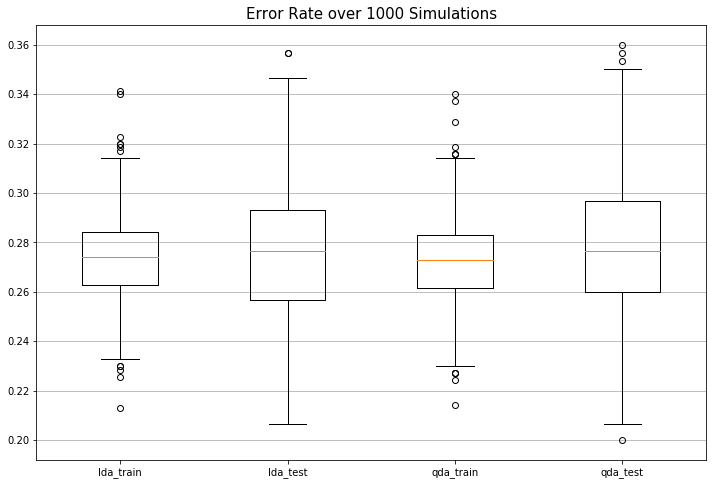

In [8]:
# Draw the boxplot
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.boxplot((error_rate.T[0], error_rate.T[1], error_rate.T[2], error_rate.T[3]), vert=True)
ax.set_xticklabels(["lda_train", "lda_test", "qda_train", "qda_test"])
ax.yaxis.grid(True)
plt.title("Error Rate over 1000 Simulations", size = 15)
plt.show()

As calculated, the average error rate of **Linear Discrimination** is **27.37%** for the training sets, **27.61%** for the testing sets; the the average error rate of **Quadratic Discrimination** is **27.26%** for the training sets, **27.69%** for the testing sets. Plus what we see from the boxplots, we now have solid evidence that **LDA can predict better on the testing set**, while **QDA can fit the training sets better**(better on the training set).

### If the Bayes decision boundary is non-linear, do we expect LDA or QDA to perform better on the training set? On the test set?

I would expect the QDA to perform better on both the training sets and the testing sets.

#### Repeat the following process 1000 times.

* (1) Simulate a dataset of 1000 observations with $X_{1}$, $X_{2}$ ~ $Uniform(−1,+1)$. $Y$ is a binary response variable defined by a Bayes decision boundary of $f(X)= X_{1} + X_1^{2} + X_{2} + X_{2}^{2}$,  where values 0 or greater are coded TRUE and values less than 0 or coded FALSE. Whereas your simulated $Y$ is a function of $X_{1} + X_1^{2} + X_{2} + X_{2}^{2} + \epsilon$, where $\epsilon$ ~ $N(0,1)$. That is, your simulated $Y$ is a function of the Bayes decision boundary plus some irreducible error.

* (2) Randomly split your dataset into 70/30% training/test sets.

* (3) Use the training dataset to estimate LDA and QDA models.

* (4) Calculate each model’s training and test error rate.

In [9]:
class DA_simulate_nonlinear:
    
    def __init__(self, seed = 1, data = None):
        self.data = data
        self.seed = seed
        
    def generate_data(self):
        np.random.seed(self.seed)
        X = np.random.uniform(-1,1,(2,1000))
        Y = ((X[0,:] + X[0,:]**2 + X[1,:] + X[1,:]**2 + np.random.normal(size = 1000))>=0)*1
        data = np.vstack((X, Y)) 
        self.data = data
    
    def split_data(self):
        seq = np.arange(1000)
        np.random.seed(self.seed)
        np.random.shuffle(seq)
        train_idx = seq[:700]; test_idx = seq[700:]
        return self.data[:,train_idx], self.data[:,test_idx]
    
    def LD(self, data, model):
        X_var = data[:2,:].T; y = data[2,:].T
        if model=='LDA':
            lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
            res = lda.fit(X_var, y)
        elif model=='QDA':
            qda = QuadraticDiscriminantAnalysis(store_covariance=True)
            res = qda.fit(X_var, y)
        else:
            raise ValueError('model must be either LDA or QDA')
        return res
    
    def error_rate(self):
        train, test = self.split_data()
        lda = self.LD(train,model='LDA'); qda = self.LD(train,model = 'QDA')
        lda_train = (lda.predict(train[:2,:].T)!=train[2,:]).sum()/train.shape[1] 
        lda_test = (lda.predict(test[:2,:].T)!=test[2,:]).sum()/test.shape[1]
        qda_train = (qda.predict(train[:2,:].T)!=train[2,:]).sum()/train.shape[1]
        qda_test = (qda.predict(test[:2,:].T)!=test[2,:]).sum()/test.shape[1]
        return lda_train, lda_test, qda_train, qda_test

In [10]:
# Try the simulation
sim = DA_simulate_nonlinear(1)
sim.generate_data()
error_rate = np.array([sim.error_rate()])

In [11]:
error_rate

array([[0.25857143, 0.26      , 0.26142857, 0.23666667]])

In [12]:
# Proceed with additional 999 trials
for seed in range(2, 1001):
    sim = DA_simulate_nonlinear(seed)
    sim.generate_data()
    error_rate = np.vstack((error_rate, np.array([sim.error_rate()])))

In [13]:
error_rate

array([[0.25857143, 0.26      , 0.26142857, 0.23666667],
       [0.25571429, 0.27      , 0.24      , 0.27666667],
       [0.29714286, 0.23      , 0.27285714, 0.23333333],
       ...,
       [0.29571429, 0.26      , 0.27285714, 0.27333333],
       [0.27      , 0.27666667, 0.27142857, 0.27      ],
       [0.28285714, 0.3       , 0.26571429, 0.29      ]])

#### Summarize all the simulations’ error rates and report the results in tabular and graphical form. Use this evidence to support your answer.

In [14]:
error_rate.mean(axis = 0)

array([0.27218286, 0.27514667, 0.25898714, 0.26201   ])

|Group | Error Rate |
|------|------------|
|LDA_train| 27.37%  |
|LDA_test | 27.51%  |
|QDA_train| 25.90%  |
|QDA_train| 26.20%  |

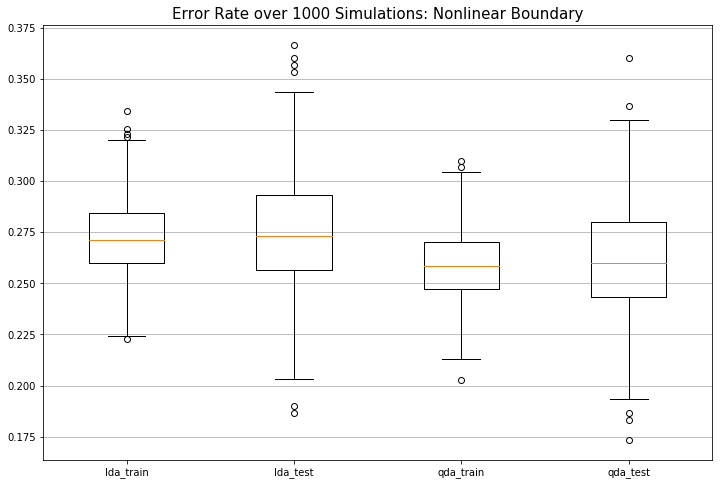

In [15]:
# Draw the boxplot
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.boxplot((error_rate.T[0], error_rate.T[1], error_rate.T[2], error_rate.T[3]), vert=True)
ax.set_xticklabels(["lda_train", "lda_test", "qda_train", "qda_test"])
ax.yaxis.grid(True)
plt.title("Error Rate over 1000 Simulations: Nonlinear Boundary", size = 15)
plt.show()

As calculated, the average error rate of **Linear Discrimination** is **27.22%** for the training sets, **27.51%** for the testing sets; the the average error rate of **Quadratic Discrimination** is **25.90%** for the training sets, **26.20%** for the testing sets. Plus what we see from the boxplots, we now have solid evidence that **QDA both fit the training data better and predict the testing sets better**, when the Bayes boundary is not linear.

### In general, as sample size $n$ increases, do we expect the test error rate of QDA relative to LDA to improve, decline, or be unchanged? Why?

Whtn the sample size increases, I would expect the both QDA and LDA to frow their prediction capabilities, and QDA may have a greater improvement.

In [16]:
class DA_simulate_nonlinear_vobs:
    
    def __init__(self, seed = 1, nobs = 1000, data = None):
        self.data = data
        self.seed = seed
        self.nobs = nobs
        
    def generate_data(self):
        np.random.seed(self.seed)
        X = np.random.uniform(-1,1,(2, self.nobs))
        Y = ((X[0,:] + X[0,:]**2 + X[1,:] + X[1,:]**2 + np.random.normal(size = self.nobs))>=0)*1
        data = np.vstack((X, Y)) 
        self.data = data
    
    def split_data(self):
        seq = np.arange(self.nobs)
        np.random.seed(self.seed)
        np.random.shuffle(seq)
        train_idx = seq[:int(0.7*self.nobs)]; test_idx = seq[int(0.7*self.nobs):]
        return self.data[:,train_idx], self.data[:,test_idx]
    
    def LD(self, data, model):
        X_var = data[:2,:].T; y = data[2,:].T
        if model=='LDA':
            lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
            res = lda.fit(X_var, y)
        elif model=='QDA':
            qda = QuadraticDiscriminantAnalysis(store_covariance=True)
            res = qda.fit(X_var, y)
        else:
            raise ValueError('model must be either LDA or QDA')
        return res
    
    def error_rate(self):
        train, test = self.split_data()
        lda = self.LD(train,model='LDA'); qda = self.LD(train,model = 'QDA')
        lda_train = (lda.predict(train[:2,:].T)!=train[2,:]).sum()/train.shape[1] 
        lda_test = (lda.predict(test[:2,:].T)!=test[2,:]).sum()/test.shape[1]
        qda_train = (qda.predict(train[:2,:].T)!=train[2,:]).sum()/train.shape[1]
        qda_test = (qda.predict(test[:2,:].T)!=test[2,:]).sum()/test.shape[1]
        return lda_train, lda_test, qda_train, qda_test

#### Use the non-linear Bayes decision boundary approach from part (2) and vary $n$ across your simulations.

In [17]:
errors = []

for n in [10**2, 10**3, 10**4, 10**5]:
    sim = DA_simulate_nonlinear_vobs(1, n)
    sim.generate_data()
    error_rate = np.array([sim.error_rate()])
    for seed in range(2, 1001):
        sim = DA_simulate_nonlinear_vobs(seed, n)
        sim.generate_data()
        error_rate = np.vstack((error_rate, np.array([sim.error_rate()])))
    errors.append(error_rate.mean(axis = 0))

In [18]:
errors = np.array(errors)

In [19]:
errors

array([[0.26155714, 0.291     , 0.23847143, 0.2754    ],
       [0.27218286, 0.27514667, 0.25898714, 0.26201   ],
       [0.27351743, 0.273386  , 0.260696  , 0.26059433],
       [0.27346231, 0.27342533, 0.26062903, 0.26057177]])

Here we tabulate the error rates' changes over numbers of simulations:

|Error Rate         |
|-------------------|
|**# Simulations** | **LDA_train** | **LDA_test** | **QDA_train** | **QDA_train** |
|**100**| 26.16%  |29.1%|23.85%|27.54%|
|**1000** | 27.22%  |27.51%|25.90%|26.20%|
|**10000**| 27.35%  |27.339%|26.07%|26.059%|
|**100000**| 27.35% |27.343%|26.06%|26.057%|

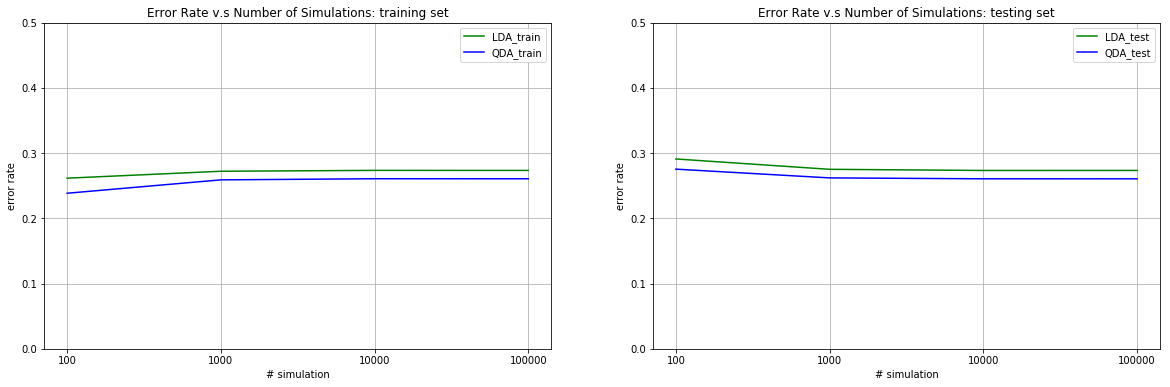

In [20]:
# Graphical Interpretation

fig, axes = plt.subplots(1,2)
x = np.log10([100, 1000, 10000, 100000])
fig.set_size_inches(20,6)
ax = axes[0]
ax.plot(x, errors[:,0], color = 'g', label = 'LDA_train')
ax.plot(x, errors[:,2], color = 'b', label = 'QDA_train')
ax.set_xticks([2, 3, 4, 5]); ax.set_xticklabels([100, 1000, 10000, 100000])
ax.set_title("Error Rate v.s Number of Simulations: training set")
ax.set_xlabel("# simulation"); ax.set_ylabel("error rate")
ax.set_ylim(0, 0.5)
ax.legend(); ax.grid()

ax = axes[1]
ax.plot(x, errors[:,1], color = 'g', label = 'LDA_test')
ax.plot(x, errors[:,3], color = 'b', label = 'QDA_test')
ax.set_xticks([2, 3, 4, 5]); ax.set_xticklabels([100, 1000, 10000, 100000])
ax.set_title("Error Rate v.s Number of Simulations: testing set")
ax.set_xlabel("# simulation"); ax.set_ylabel("error rate")
ax.set_ylim(0, 0.5)
ax.legend(); ax.grid()

plt.show()

As the table and the graphs indicate, for the training sets, both LDA and QDA tend to have bigger error rates as N increases. This is because larger samples are harder to fit with relatively inflexible models. While both models predict better on the testing sets, as the models we estimate now are closer to the true model, with more observations. And QDA seems to increase faster in terms of predicting accuracy, and the relative error rate to LDA declines.

### True or False: Even if the Bayes decision boundary for a given problem is linear, we will probably achieve a superior test error rate using QDA rather than LDA because QDA is flexible enough to model a linear decision boundary. Justify your answer.

I think the statement is false. The QDA might be able to fit the training set better, as it is more flexible. But it might in the meantime overfit the training data and perform worse in doing out of sample prediction, especially when the true Bayes decision boundary is linear.

# Modeling voter turnout

In [21]:
# import the data
mh = pd.read_csv("data/mental_health.csv")

In [22]:
# remove the NANs
mh = mh.dropna(axis = 0, how='any')

In [23]:
mh.head()

,vote96,mhealth_sum,age,educ,black,female,married,inc10
0,1.0,0.0,60.0,12.0,0,0,0.0,4.8149
2,1.0,1.0,36.0,12.0,0,0,1.0,8.8273
3,0.0,7.0,21.0,13.0,0,0,0.0,1.7387
7,0.0,6.0,29.0,13.0,0,0,0.0,10.6998
11,1.0,1.0,41.0,15.0,1,1,1.0,8.8273


## Split the data into a training and test set (70/30).

In [24]:
np.random.seed(30100)
idx = np.arange(mh.shape[0])
np.random.shuffle(idx)
idx_train = idx[:int(mh.shape[0]*0.7)]; idx_test = idx[int(mh.shape[0]*0.7):]
train = mh.iloc[idx_train,:]; test = mh.iloc[idx_test,:]

## Using the training set and all available predictors, estimate the following models with vote96 as the response variable:

### Logistic regression model

In [25]:
x_train = train.iloc[:,1:]; y_train = train['vote96']

m_logit = LogisticRegression()
res_logit = m_logit.fit(sm.add_constant(x_train), y_train)

### Linear discriminant model

In [26]:
m_lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
res_lda = m_lda.fit(x_train, y_train)

### Quadratic discriminant model

In [27]:
m_qda = QuadraticDiscriminantAnalysis(store_covariance=True)
res_qda = m_qda.fit(x_train, y_train)

### Naive Bayes - you can use the default hyperparameter settings

In [28]:
m_nb = GaussianNB()
res_nb = m_nb.fit(x_train, y_train)

### $K$-nearest neighbors with $K=1,2,...,10$ (that is, 10 separate models varying $K$) and Euclidean distance metrics

In [29]:
m_knn = []; res_knn = []
for k in range(1,11):
    m = KNeighborsClassifier(n_neighbors=k)
    res = m.fit(x_train, y_train)
    m_knn.append(m); res_knn.append(res)

## Using the test set, calculate the following model performance metrics:

In [30]:
x_test = test.iloc[:,1:]; y_test = test['vote96']

In [31]:
# Compute the error rates of all the previous models, using the testing dataset
pred_logit = res_logit.predict(sm.add_constant(x_test))
pred_lda = res_lda.predict(x_test)
pred_qda = res_qda.predict(x_test)
pred_nb = res_nb.predict(x_test)
pred_knn = []
for i in range(10):
    pred_knn.append(res_knn[i].predict(x_test))

### Error rate

In [32]:
l = y_test.shape[0]
error_logit = (np.array(pred_logit) != y_test).sum()/l
error_lda = (np.array(pred_lda) != y_test).sum()/l
error_qda = (np.array(pred_qda) != y_test).sum()/l
error_nb = (np.array(pred_nb) != y_test).sum()/l
error_knn = []
for i in range(10):
    error_knn.append((np.array(pred_knn[i]) != y_test).sum()/l)

error_rates = [error_logit, error_lda, error_qda, error_nb] + error_knn

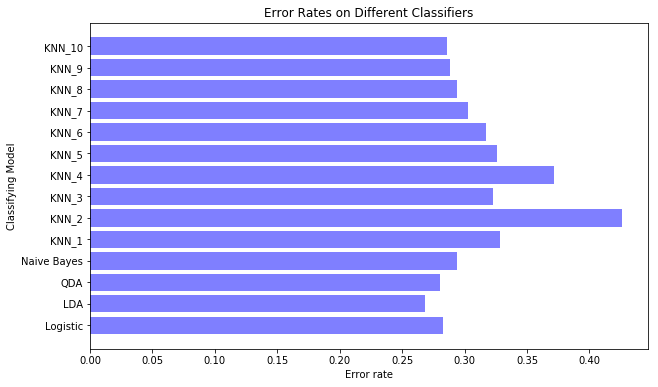

In [33]:
model = ['Logistic', 'LDA', 'QDA', 'Naive Bayes'] + ['KNN_'+str(i) for i in range(1,11)]

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.barh(range(len(model)), error_rates, color = 'b', alpha = 0.5)
ax.set_yticks(range(len(model)))
ax.set_yticklabels(model)
ax.set_xlabel('Error rate'); ax.set_ylabel('Classifying Model')
ax.set_title('Error Rates on Different Classifiers')
plt.show()

### Proporitional Reduction in Error

In [34]:
error_null = 1 - y_test.sum()/y_test.shape[0]
PRE = [(error_null - i)/error_null for i in error_rates]

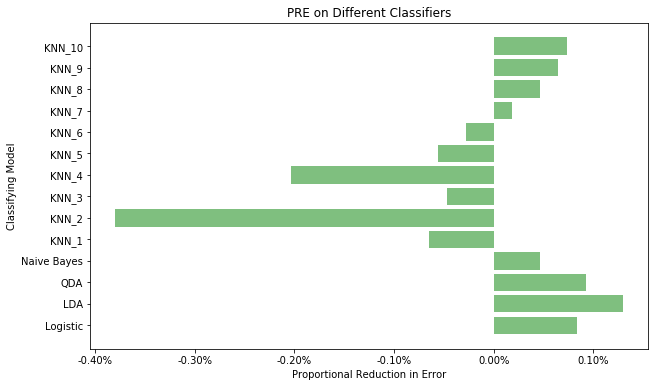

In [35]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.barh(range(len(model)), PRE, color = 'g', alpha = 0.5)
ax.set_yticks(range(len(model)))
ax.set_yticklabels(model)
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xlabel('Proportional Reduction in Error'); ax.set_ylabel('Classifying Model')
ax.set_title('PRE on Different Classifiers')
plt.show()

### ROC curve & AUC

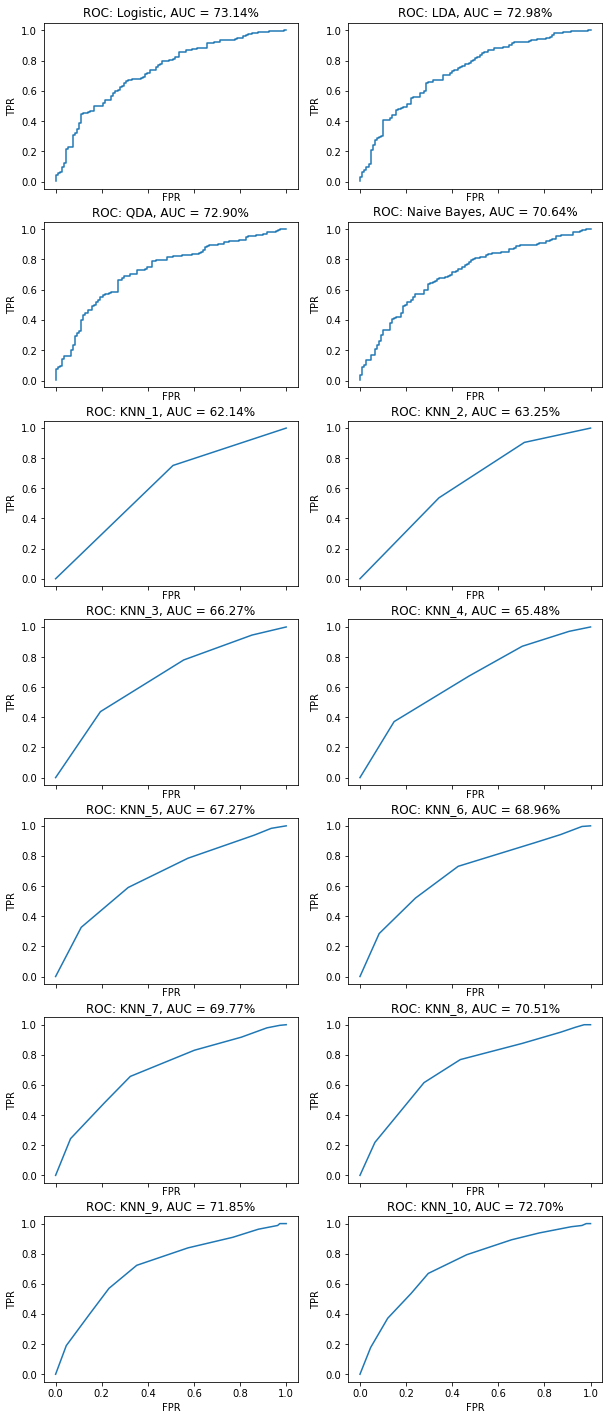

In [36]:
res = [res_logit, res_lda, res_qda, res_nb] + res_knn

fig, axes = plt.subplots(7, 2,sharex=True)
fig.set_size_inches(10, 25)
ax = axes[0][0]
y_score = res_logit.decision_function(sm.add_constant(x_test))
fpr, tpr, _ = roc_curve(y_test, y_score)
ax.plot(fpr, tpr)
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
ax.set_title('ROC: Logistic, AUC = {:.2%}'.format(auc(fpr, tpr)))
ax = axes[0][1]
y_score = res_lda.decision_function(x_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
ax.plot(fpr, tpr)
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
ax.set_title('ROC: LDA, AUC = {:.2%}'.format(auc(fpr, tpr)))
for i in range(1,7):
    for j in range(2):
        ax = axes[i][j]
        y_score = res[2*i+j].predict_proba(x_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        ax.plot(fpr, tpr)
        ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
        ax.set_title('ROC: {}, AUC = {:.2%}'.format(model[2*i+j], auc(fpr, tpr)))
plt.show()

## Which model performs the best? Be sure to define what you mean by “best” and identify supporting evidence to support your conclusion(s).

Since our main goal here is to reach the best prediction, I would take these predicting diagnostics more seriously. Therefore, my best-performance model is the **LDA model**, which has the lowest error rate (26.86%), the most PRE (12.96%) and the second best AUC (72.98%). In addition, since it is a linear model and we have coefficient estimates, it is also quite interpretable in a way.